# **Group Project Final Report: Predicting Subscription Status of Game-related newsletter**


## **I. Introduction**

**Background Information:**  This data was collected through the Minecraft servers ran by UBC Computer Science students. This is real data, meaning all the players are real people and all the sessions are real gaming sessions recorded. Players registered their information and the servers recorded the moment they launched the game and the second they stopped playing the game.

**Question:** In `players.csv`, can the total amount of hours played and experience predict whether a gamer will subscribe to a gaming newsletter?

Target variable: `subscribe`

Predictor variables: `played_hours` and `experience`

**Let's load the data and library**


In [4]:
set.seed(4235)
library(tidyverse)
library(tidymodels)
library(janitor)
library(RColorBrewer)
library(dplyr)
library(themis)

In [5]:
sessions_data <- read_csv("https://raw.githubusercontent.com/duybau2006/Data-Science-100-Group-Project/refs/heads/main/sessions.csv")
players_data <- read_csv("https://raw.githubusercontent.com/duybau2006/Data-Science-100-Group-Project/refs/heads/main/players.csv")
players_data <- clean_names(players_data)
head(players_data)

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashed_email,played_hours,name,gender,age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


**Dataset:** We will be working with the players dataset (`players.csv`) only, and not with the sessions dataset (`sessions.csv`). Here are some details on the dataset we will be working on:
- Contains 196 observations, where each observation represents a unique player.
- This dataset represents a player; thus, name, age, and gender are included. In addition, the player's private and unique hashed email is also present along with their played hours, experience, and whether are not they are subscribed to the Minecraft server.
- 7 variables:
  + `experience` *<chr>*: Skill level of each player (Beginner, Regular, Amateur, Pro, Veteran), stored as a character data type
  + `subscribe` *<lgl>*: Whether the player is subscribed, stored as a logical data type (TRUE/FALSE)
  + `hashedEmail` *(chr)*: Unique identifier for each player, stored as a character data type
  + `played_hours` *(dbl)*: Total time (in hours) the player has spent on the server, stored as a double data type
  + `name` *(chr)*: Player's name, stored as a character data type
  + `gender` *(chr)*: Player's preferred gender (7 categories), represented as a character data type
  + `Age` *(dbl)*: Player's age (8 to 50 years), stored as a double data type

**Potential Issues:**
- `experience` should be a categorical data type instead of a character (chr). This would help in visualization, data intepretation, and generating more accurate and effective summary statistics.
- `gender` should also be categorical for the same reason.
- All numerical data (`played_hours` and `age`) must be standardized if they are to be used in prediction. This is because unstandardized data could cause issues and disproportionately influence k-nearest neighbor or other predictive models, reducing accuracy and lread to incorrect predictions.
- Some `age` values are missing, potentially causing problems with data analysis. 

## **II. Methods & Results**

**Loading the datasets**

In [6]:
players_data <- read_csv("https://raw.githubusercontent.com/duybau2006/Data-Science-100-Group-Project/refs/heads/main/players.csv")
sessions_data <- read_csv("https://raw.githubusercontent.com/duybau2006/Data-Science-100-Group-Project/refs/heads/main/sessions.csv")

head(players_data)
head(sessions_data)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


**Wrangling and cleaning the needed dataset**

Here, we changed the data types of each variable:
- `experience`: from *chr* to *fct*
- `gender`: from *chr* to *fct*
- `subscribe`: from *lgl* to *fct*

We also changed the values inside the variable `subscribe` for better visualizations:
- **TRUE** to **Yes**
- **FALSE** to **No**

In [7]:
players_tidy <- players_data |>
mutate(experience = as_factor(experience),
       gender = as_factor(gender),
       subscribe = as_factor(subscribe),
       subscribe = fct_recode(subscribe, "Yes" = "TRUE", "No" = "FALSE"))

**General summary of the dataset used**

Since we are trying to predict whether a gamer will subscribe to a gaming newsletter or not using the total amount of hours played and their experience, we will only be looking into these variables: `subscribe`, `played_hours` and `experience`.
- `player_experience`: We group the data by the categories within the experience variable then find the count and proportions of each level of experience
- `player_subscribed`: We did the same thing as `player_experience` except we find how many people subscribed and how many didn't
- `avg_played_hours`: We dropped the N/A values within the played_hours variable and calculate the mean of it

***Findings:***
- The average total play time is around 5.85 hours
- Most players are subscribed:
  + `Yes`: 73.47% (144 players)
  + `No`: 26.53% (52 players)
- The majority of players fall into the Amateur and Veteran categories, comprising over 50% of the total players. In contrast, Pro players are the least represented group in the dataset:
  + `Amateur`: 32.14% (63 players)
  + `Veteran`: 24.49% (48 players)
  + `Regular`: 18.37% (36 players)
  + `Beginner`: 17.86% (35 players)
  + `Pro`: 7.14% (14 players)
- The majority of players who subscribed were Amateur players, though this does not mean that Amateur players are most likely to subscribe because they are the highest populated group.

In [8]:
#number of players based on experience
player_experience <- players_tidy |>
                group_by(experience) |>
                summarize(count = n()) |>
                mutate(percentage = count / sum(count) * 100)|>
                arrange(desc(count))
player_experience

#number of players based on whether or not they are subscribed
player_subscribed <- players_tidy |>
                group_by(subscribe) |>
                summarize(count = n()) |>
                mutate(percentage = count / sum(count) * 100)|>
                arrange(desc(count))
player_subscribed

#finding average played hours
avg_played_hours <- players_tidy |>
            summarize(avg_played_hours = mean(played_hours, na.rm = TRUE))
avg_played_hours



experience,count,percentage
<fct>,<int>,<dbl>
Amateur,63,32.142857
Veteran,48,24.489796
Regular,36,18.367347
Beginner,35,17.857143
Pro,14,7.142857


subscribe,count,percentage
<fct>,<int>,<dbl>
Yes,144,73.46939
No,52,26.53061


avg_played_hours
<dbl>
5.845918


**Visualization of the datasets**

Here, we decided to set up the bar graphs for:
- Number of players based on the level of experience
- Number of players based on whether they are subscribed or not
- Number of players who are subscribed based on their level of experience

This helps us visualize the data better and see how well subscription status is connected to the level of experience to answer our initial question much easier.

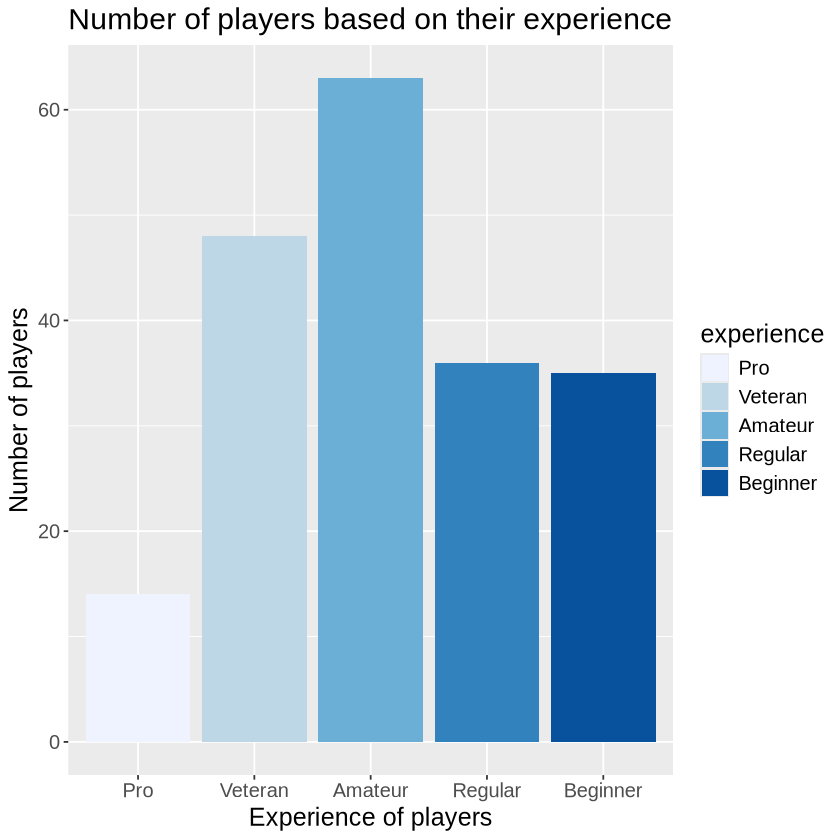

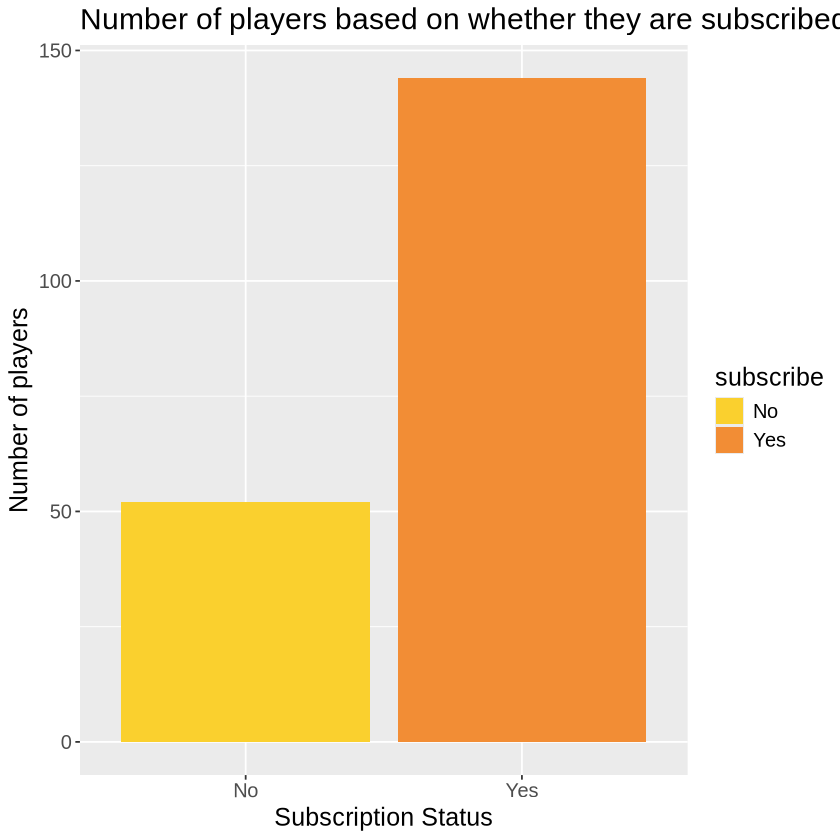

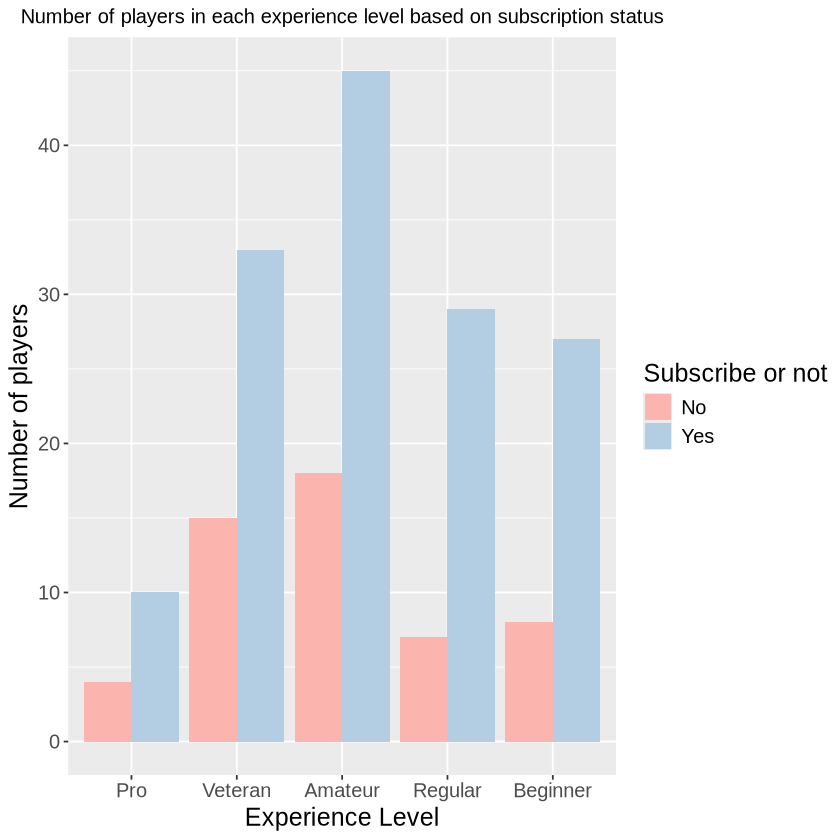

In [9]:
#Bar graph of the level of experience of players
player_experience_plot <- player_experience |>
    ggplot(aes(x = experience, y = count, fill = experience)) + 
    geom_bar(stat = "identity") + 
    labs(x = "Experience of players", 
         y = "Number of players") +
    ggtitle("Number of players based on their experience") +
    scale_fill_brewer(palette = "Blues") +
    theme(text = element_text(size = 15))
player_experience_plot

#Bar graph of the subscription of players
player_subscribe_plot <- player_subscribed |>
    ggplot(aes(x = subscribe, y = count, fill = fct_reorder(subscribe, count))) + 
    geom_bar(stat = "identity") + 
    labs(x = "Subscription Status", 
         y = "Number of players",
        fill = "subscribe") +
    ggtitle("Number of players based on whether they are subscribed or not") +
    scale_fill_manual(values = c("No" = "#FAD02E", "Yes" = "#F28D35")) + 
    theme(text = element_text(size = 15))
player_subscribe_plot

#Bar graph of proportions of each level of experience that subscribed and not
player_subscribe_experience <- ggplot(players_tidy, aes(x= experience, fill = subscribe)) + 
    geom_bar(position = "dodge") +  
    labs(x = "Experience Level", 
         y = "Number of players",
         fill = "Subscribe or not") +
    ggtitle("Number of players in each experience level based on subscription status") +  
    scale_fill_brewer(palette = "Pastel1") +
    theme(text = element_text(size = 15), 
          plot.title = element_text(hjust = 0.5, size = 12)) 
player_subscribe_experience

**Data analysis**

***Assess accuracy***

Since we are trying to predict a category, we must use the classification model. Our plan is to pick a model with the highest accuracy:
- Split the players' data set into two different sets and utilize strata = subscribe to ensure that the training and testing subsets contain the right proportions of each category of observation:
  + 75% will be the training set
  + 25% will be the testing set
- Next, we standardize the variables for our recipe which is essential for KNN because it is distance-based. We also ensure unsampling is skipped when using the test data.
- Since we want to know which k-value is best for our model, we used cross-validation and have 5 different folds.
- We created a tibble of k values between 1 and 49 (odd numbers), and collected the accuracy for each.
- Then we sort by the highest mean accuracy from cross-validation and extract the best neighbors to use for our model.

In [10]:
players_split <- initial_split(players_tidy, prop = 0.75, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

players_recipe <- recipe(subscribe ~ experience + played_hours,
                        data = players_train) |>
  step_upsample(subscribe, over_ratio = 1, skip = TRUE) |>
  step_scale(played_hours) |>
  step_center(played_hours)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 2))

knn_results <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = players_vfold, grid = k_vals) |>
  collect_metrics()

accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracies

best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5036946,5,0.03279064,Preprocessor1_Model01
3,accuracy,binary,0.4824959,5,0.02633186,Preprocessor1_Model02
5,accuracy,binary,0.4629885,5,0.01535419,Preprocessor1_Model03
7,accuracy,binary,0.4567980,5,0.03428391,Preprocessor1_Model04
9,accuracy,binary,0.4432184,5,0.03633093,Preprocessor1_Model05
11,accuracy,binary,0.4627586,5,0.03451837,Preprocessor1_Model06
13,accuracy,binary,0.4358621,5,0.03382788,Preprocessor1_Model07
15,accuracy,binary,0.4506076,5,0.04347504,Preprocessor1_Model08
17,accuracy,binary,0.4105911,5,0.05079520,Preprocessor1_Model09


[1] 1

***Fitting the highest accuracy k onto our testing set***
- Here, we found the best k value (k = 35) and fit it on the training data, creating a model that we can use
- Then we use this model to make predictions on the test dataset and evaluate the accuracy of it

In [11]:
knn_spec_best <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit_best <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_spec_best) |>
  fit(data = players_train)

knn_fit_best

players_test_predictions <- predict(knn_fit_best, players_test) |>
  bind_cols(players_test)

players_test_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
3 Recipe Steps

• step_upsample()
• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(1,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3194444
Best kernel: rectangular
Best k: 1

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.4081633


The confusion matrix is the **following**: This helps us evaluate the performance of our classification model

In [12]:
confusion <- players_test_predictions |>
             conf_mat(truth = subscribe, estimate = .pred_class)
confusion

          Truth
Prediction No Yes
       No  12  28
       Yes  1   8

**Visualization of the analysis:**

We choose to visualize two important graphs:
- A line graph showing different values of k and the accuracy that each model with the respective k has. It allows us to see which value of k has the highest accuracy
- A bar graph comparing prediction distributions, it allow us to see whether we are overpredicting or underpredicting a certain class

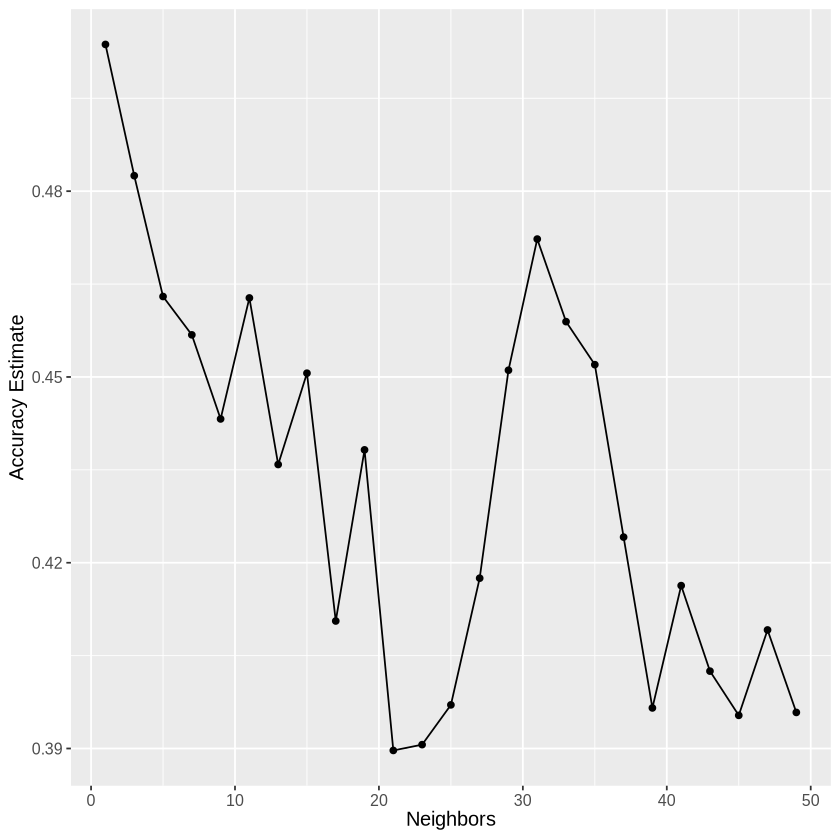

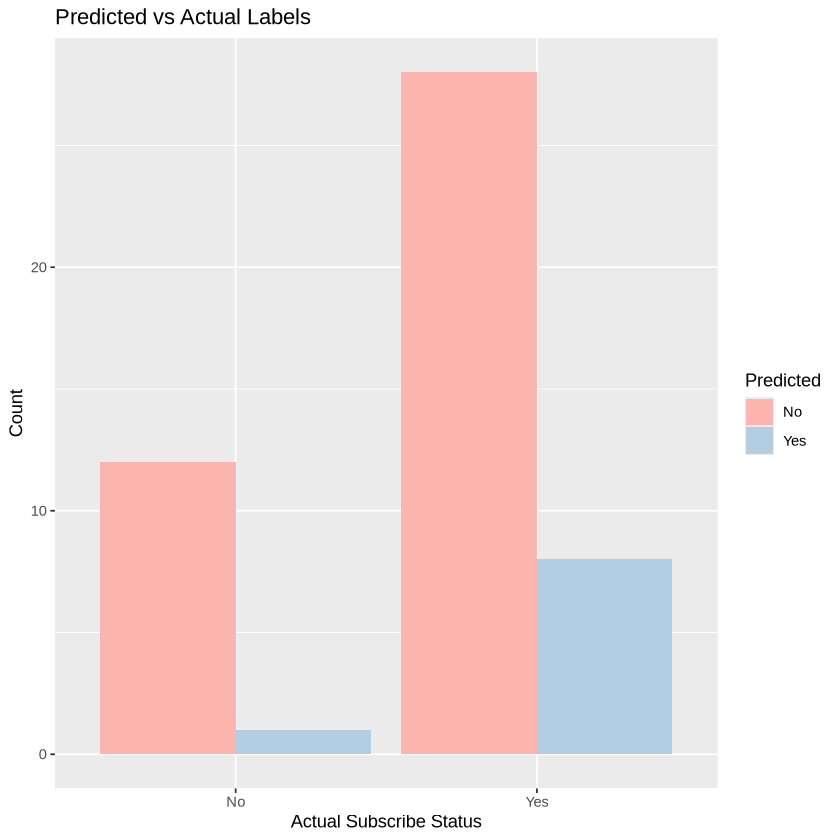

In [13]:
# to choose the best K-value
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))

accuracy_vs_k

## NOTE
## DRAFT
predictions_plot <- players_test_predictions |>
    count(subscribe, .pred_class) |>
    ggplot(aes(x = subscribe, y = n, fill = .pred_class)) +
    geom_bar(stat = "identity", position = "dodge") +
    scale_fill_brewer(palette = "Pastel1") +
    labs(x = "Actual Subscribe Status", y = "Count", fill = "Predicted") +
    ggtitle("Predicted vs Actual Labels")
predictions_plot


## **III. Discussion**

**Summary of what we found**

...

**Whether this is what we expected to find**

...

**What impact could our findings have**

...

**Future questions this lead to**

...

## **References**

...